# Цель работы

Есть обезличенный набор признаков товаров интернет- магазина. Требуется  разработать алгоритм, который предложит несколько вариантов наиболее похожих товаров. Целевая метрика -  accuracy@5 >=0,8 на валидационной выборке.

# Импорт библиотек

In [1]:
!apt install libomp-dev
!pip install faiss-gpu

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libomp-14-dev libomp5-14
Suggested packages:
  libomp-14-doc
The following NEW packages will be installed:
  libomp-14-dev libomp-dev libomp5-14
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 738 kB of archives.
After this operation, 8,991 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp5-14 amd64 1:14.0.0-1ubuntu1.1 [389 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp-14-dev amd64 1:14.0.0-1ubuntu1.1 [347 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libomp-dev amd64 1:14.0-55~exp2 [3,074 B]
Fetched 738 kB in 2s (354 kB/s)
Selecting previously unselected package libomp5-14:amd64.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../libomp5-14_1%3a14

In [15]:
import faiss
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler

import os
import re
import matplotlib.pyplot as plt

# Загрузка и анализ данных

In [3]:
data_train = pd.read_csv('drive/MyDrive/Colab Notebooks/data/train.csv', index_col=0)
data_valid = pd.read_csv('drive/MyDrive/Colab Notebooks/data/validation.csv', index_col=0)
data_answers = pd.read_csv('drive/MyDrive/Colab Notebooks/data/validation_answer.csv', index_col=0)
data_base = pd.read_csv('drive/MyDrive/Colab Notebooks/data/base.csv', index_col=0)


data = {
    'train': data_train,
    'valid': data_valid,
    'answer': data_answers,
    'common': data_base
}

In [4]:
#data_base = data_base[:30000]
#data_base_sh.head()

### Анализ на наличие пропусков, дубликатов, тип данных, количество признаков

In [5]:
#for key in data.keys():
  #print(f'DATASET---{key}')
  #print('----------')
  #print(f'SHAPE = {data[key].shape}')
  #print(f'DATA TYPES {data[key].dtypes}')
  #print(f'MISSED = {data[key].isna().sum()}')
  #print(f'FULL DUPLICATES = {data[key].duplicated().sum()}')
  #print('----------\n')

In [6]:
data_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,-88.08269,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.84137,-78.512180,-94.42894,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.821840,149.71584,-27.042316,-133.21217,106.420746,-303.939233,48.73079,58.185707,24.250950,-151.22410,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.99164,-31.948470,82.314430,-115.830470,-243.30939,6.622036,-132.197660,68.71256,-38.806824,62.937435,-132.65445,89.189026,87.039780,-121.27988,-6.986934,-206.513820,29.485587,-77.029590,-132.38617,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,-177.60580,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.26703,-78.659430,-92.76149,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.783450,153.35791,48.810093,-115.92215,87.464220,-222.286354,25.12415,91.887140,-30.636870,-136.59314,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.15090,-18.751057,95.315384,-60.093273,-83.82058,37.449867,-23.298859,74.06108,-7.139753,75.862400,-112.04511,82.857730,54.067215,-134.00539,-26.142574,-214.632110,-457.848461,21.459618,-137.41136,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,-86.34656,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.50568,-78.372925,-69.32448,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.321780,158.76062,0.178065,-183.06967,99.053570,-1018.469545,-51.80112,97.766770,-10.865850,-144.42316,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.63953,-30.211614,48.527400,-122.406640,-112.71362,53.461838,-31.117260,107.84151,16.482935,77.934480,-95.61873,91.460075,63.119510,-126.93925,8.066627,-195.677670,-163.120000,-72.830000,-139.22307,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,-146.51707,-159.469850,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.90683,-78.789320,-78.73709,1507.231274,19.957405,34.834290,-8.820732,813.770071,-125.606800,17.584084,-58.452904,141.28180,-54.959310,-136.98854,63.880493,-1018.469545,89.22893,65.919960,-24.078644,-152.33410,-91.199380,-28.225390,-4.767386,0.158236,-129.128660,122.95837,-30.800995,123.623400,-37.540867,-72.13980,71.240990,-168.115590,118.23645,-18.065195,37.255720,-137.69104,87.500770,62.437290,-131.26064,35.692660,-86.038830,-379.339090,-153.465770,-131.19829,-61.567047,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,-107.15302,-8.800034,-50.977800,29.457338,143.389310,5.614824,-45.274760,9.643625,-77.55463,-79.066610,-77.92646,1507.231274,16.612400,116.284290,33.754898,813.770071,-105.765335,6.523008,-19.812988,157.69392,-20.604088,-146.59128,78.849570,-780.449185,87.56077,73.036660,16.891030,-144.65790,-116.122150,-19.353254,-7.709266,-5.394988,-140.252120,193.18497,-53.147078,79.869446,-151.131350,-45.05616,79.796234,46.763016,47.68181,-

In [7]:
data_valid.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.89280,-140.968570,-57.987164,-22.868887,150.89552,7.965574,17.622066,-34.868217,-216.13855,-80.908730,-52.579520,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.30708,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.16277,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.124000,-24.996636,76.153900,-245.26157,-143.65648,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.48687,-39.484753,-124.384575,-307.949760,45.506813,-144.19095,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.71725,-63.951330,-52.369495,-33.390945,148.61950,-22.483830,15.164185,-56.202000,-153.61438,-79.831825,-101.055480,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.38391,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.53838,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.953950,-18.408230,90.517050,-95.53100,-259.63605,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.07526,-25.169033,-176.176880,-655.836897,-99.238370,-141.53522,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.30954,-31.378445,-8.788761,2.285323,133.26611,-41.309080,14.305538,-18.231812,-205.53370,-78.160310,-96.607670,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.36850,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.93462,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.276150,-45.909942,103.491360,-90.65699,-162.61570,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.56618,-12.822194,-154.197650,-407.199067,5.522629,-126.81297,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,-114.27196,-71.406456,-65.349320,24.377070,50.46730,-14.721335,15.069309,-46.682995,-176.60437,-78.690700,-139.227450,325.547112,3.632292,74.929504,-4.802103,813.770071,-52.982597,15.644381,-54.087467,151.30914,21.088570,-134.507890,65.118960,-529.295053,131.565520,67.642700,-22.884491,-145.90652,-86.917330,-11.863579,-22.188885,0.463720,-212.533750,170.522580,-48.092532,99.712555,-194.69241,-141.52318,60.217050,73.386380,118.567856,58.900810,55.569030,-181.091660,83.340485,66.083240,-114.04887,-57.156870,-56.335075,-318.680065,-15.984783,-128.10133,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,-76.21417,-26.393860,34.423640,50.938890,157.68318,-23.786497,-33.175415,-0.592607,-193.31854,-79.651030,-91.889786,1358.481072,44.027733,121.527210,46.183000,433.623103,-82.233200,21.068508,-32.940117,149.26895,0.404718,-97.674530,81.719990,-825.644804,9.397169,49.359340,17.725466,-160.16815,-129.367950,-55.532898,-2.597821,-0.226103,-41.369140,92.090195,-58.626857,73.655440,-10.25737,-175.65678,25.395056,47.874825,51.464676,140.951680,58.751133,-215.487640,91.255

In [8]:
data_answers.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [9]:
data_base.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.06151,-32.458237,-57.420560,36.207405,182.71677,-28.071688,-5.209374,-1.732182,-91.09186,-79.46667,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.00504,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.34058,-123.62608,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.51361,-44.659496,-80.44221,5.149714,-64.518950,-138.77763,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.30435,-126.768900,-68.853530,8.314717,143.08174,8.778257,15.157185,48.246360,-244.95486,-80.27942,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.36995,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.55263,-110.34017,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.77705,58.887608,-71.59534,-251.952358,11.392853,-148.57166,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.82245,-22.486748,-51.666990,2.521726,140.58545,-22.039230,-7.128634,-5.184787,-111.71212,-79.02927,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.38771,-21.483440,-144.84537,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.06166,-118.75855,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.32137,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.73389,65.320880,-114.03718,-529.396956,-101.581375,-134.65822,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.47044,-104.537780,-82.388490,-79.986740,113.59631,-38.995880,-4.787360,8.327808,-124.85576,-79.10902,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.20198,10.613454,-134.93434,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.04530,-124.29577,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.76927,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.31432,7.912551,-62.18892,-540.321044,-89.588715,-149.32669,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.34245,-38.982060,-50.228867,-26.690920,135.27290,-7.510103,8.924209,111.576950,-130.83319,-79.31585,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.38553,-44.059470,-148.13185,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.37244,-123.70898,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.54037,57.695343,-67.822630,-29.389133,-34.123740,54.710550,-26.032013,90.673910,58.086998,-134.78206,77.62

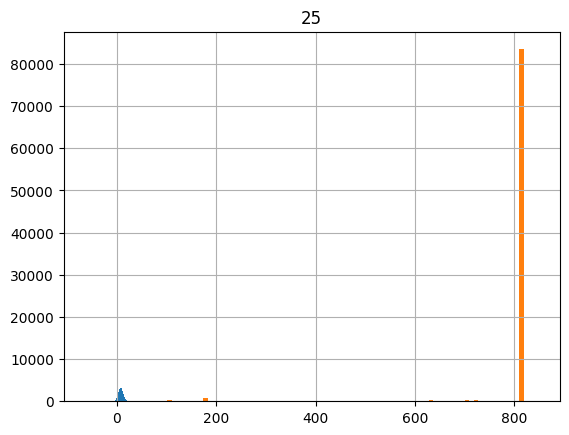

In [10]:
for c in ['1', '25']:
  data_train[c].hist(bins=100)
  plt.title(c)
  plt.savefig('drive/MyDrive/Colab Notebooks/data/hist_' + c)


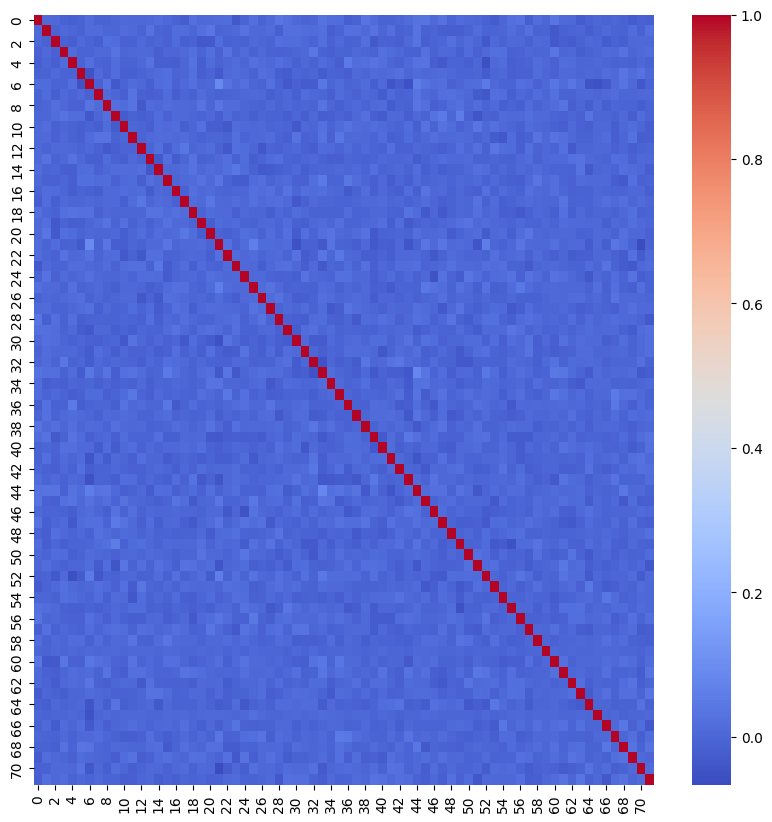

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data_train.corr(numeric_only=True), ax=ax, cmap="coolwarm")
plt.savefig('drive/MyDrive/Colab Notebooks/data/heatmap.png')


## Выводы по предварительному анализу данных
- пропусков нет
- явных дубликатов нет
- все значения, кроме таргетов, имеют тип float
- корреляции между признаками практически нет
- признаки не отмасштабированы, потребуется это сделать
- некоторые признаки (21, 25, 70) по сути являются константами (одинаковы для всех векторов). Они будут удалены.


In [12]:
const_columns = ['70', '25', '21']
data_train = data_train.drop(columns=const_columns, axis=1)
data_valid = data_valid.drop(columns=const_columns, axis=1)
data_base = data_base.drop(columns=const_columns, axis=1)

# Исследовательская часть

## План исследования
- поиск ближайших соседей производить в 2 этапа: грубый (разделение на кластеры) и точный (мэтчинг) в пределах одного кластера
- планируется рассмотреть модели:
 - для грубого поиска - FAISS и nmslib
 - для точного поиска - CatBoost, Logistic Regression


## Масштабирование признаков

In [16]:
features_train = data_train.drop(columns=['Target'], axis=1)
features_valid = data_valid
target_train = data_train['Target']
features_base = data_base

scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_base = scaler.transform(features_base)

### Запись индексов из базы и сохранение на диск

In [17]:
common_index = {k: v for k, v in enumerate(data_base.index.to_list())}

with open('drive/MyDrive/Colab Notebooks/data/common_index.pkl', 'wb') as f:
    pickle.dump(common_index, f)
#with open('common_index.pkl', 'rb') as f:
    #common_index = common_index.load(f)

In [18]:
del data_base

### Переменные данные для генерации кандидатов FAISS и сохранение индекса
- dims = размерность
- NeiNum - искомое число соседей
- n_cell - число центроидов
- batch_size - на случай формирования обучающей выборки по частям
- step - Номер шага при загрузке выборки частями

В данном случае из-за ограничений Google Colab показано обучение модели на первых 10% обучающей выборки. Теоретически. повторив в цикле то же самое несколько раз, можно собрать полную матрицу признаков.

In [19]:
dims = features_base.shape[1]
NeiNum = 100
n_cells = 200
batch_size = int(features_train.shape[0] / 10)
step = 0

In [20]:
quantizer = faiss.IndexFlatIP(dims)
idx = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx.train(np.ascontiguousarray(features_base).astype('float32'))
idx.add(np.ascontiguousarray(features_base).astype('float32'))
faiss.write_index(idx, "drive/MyDrive/Colab Notebooks/data/index.bin")
#index2 = faiss.read_index("index.bin")

### Функция для генерации кандидатов FAISS CPU

In [21]:
def faiss_gen(data, faiss_idx, batch_size, step, number):
  start = step * batch_size
  stop = start + batch_size
  dist, idx_found = faiss_idx.search(np.ascontiguousarray(data[start:stop]).astype('float32'), number)
  index_list = np.concatenate(idx_found).tolist()
  cnd = []
  for _ in index_list:
    cnd.append(features_base[_].tolist())
  return dist, idx_found, np.array(cnd)

### Функция для генерации кандидатов FAISS GPU

In [22]:
def faiss_gen_gpu(data, dimensions, batch_size, step, number):
  res = faiss.StandardGpuResources()
  index = faiss.IndexFlatL2(dimensions)
  gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
  gpu_index.add(np.ascontiguousarray(features_base).astype('float32'))
  start = step * batch_size
  stop = start + batch_size
  dist, idx_found = \
  gpu_index.search(np.ascontiguousarray(data[start:stop]).astype('float32'), number)
  index_list = np.concatenate(idx_found).tolist()
  cnd = []
  for _ in index_list:
    cnd.append(features_base[_].tolist())
  return dist, idx_found, np.array(cnd)

### Функция для расчета accuracy @ n FAISS



In [32]:
def acc_at_n(targets: pd.Series, found_idx: np.array, nei: int, batch_size, step):
  label = []
  start = step * batch_size
  stop = start + batch_size
  targets = targets.tolist()[start:stop]
  result = 0
  for i in range(len(targets)):
    candidates = []
    for number in range(nei):
      candidates.append(common_index[found_idx[i][number]])
      if targets[i] == common_index[found_idx[i][number]]:
        label.append(1)
      else:
        label.append(0)
    if targets[i] in candidates:
      result += 1

  return result / len(targets), label

### Функция для объединения данных после поиска кандидатов FAISS

In [24]:
def collect_data(distance, index, candidates, data, target, number, step, batch_size):
  dist = distance.reshape(-1, 1)
  start = step * batch_size
  stop = start + batch_size
  vectors = np.repeat(data[start:stop], number, axis=0)
  labels = np.array(target).reshape(-1, 1)
  cand_features = candidates
  cand_index = np.concatenate(index).reshape(-1, 1)
  return np.hstack((vectors, cand_features, dist, cand_index, labels))

### Грубый поиск

In [25]:
#distance, index, candidates = faiss_gen_gpu(features_train, dims, batch_size, step, NeiNum)
distance, index, candidates = faiss_gen(features_train, idx, batch_size, step, NeiNum)

### Accuracy среди 100 кандидатов

In [33]:
accuracy, labels = acc_at_n(target_train, index, NeiNum, batch_size, step)
print('ACCURACY_FAISS---', accuracy)

ACCURACY_FAISS--- 0.6551


In [37]:
#sum(labels) * 100 / 1000000

### Сборка данных в массив для точного поиска

In [38]:
preprocessed_data = collect_data(distance, index, candidates, features_train, labels, NeiNum, step, batch_size)

In [39]:
preprocessed_data.shape

(1000000, 141)

In [40]:
sum(preprocessed_data[:,140]) / (NeiNum * batch_size)

np.save('drive/MyDrive/Colab Notebooks/data/preprocessed_data.npy', preprocessed_data)

In [41]:
del candidates, index, distance

### Подготовка матрицы признаков для валидации

In [42]:
dims = features_base.shape[1]
NeiNum = 100
n_cells = 200
batch_size_v = int(features_valid.shape[0] / 20)
step = 0

In [43]:
#distance_v, index_v, candidates_v = faiss_gen_gpu(features_valid, dims, batch_size_v, step, NeiNum)
distance_v, index_v, candidates_v = faiss_gen(features_valid, idx, batch_size_v, step, NeiNum)

In [44]:
def collect_data_v(distance, index, candidates, data, number, step, batch_size):
  start = step * batch_size
  stop = start + batch_size
  index = np.concatenate(index).reshape(-1, 1)
  distance = distance.reshape(-1, 1)
  vectors = np.repeat(data[start:stop], number, axis=0)
  cand_features = candidates
  return np.hstack((vectors, cand_features, distance, index))

In [45]:
preprocessed_data_v = collect_data_v(distance_v, index_v, candidates_v, features_valid, NeiNum, step, batch_size_v)

In [46]:
preprocessed_data_v.shape

(500000, 140)

In [47]:
np.save('drive/MyDrive/Colab Notebooks/data/preprocessed_data_v.npy', preprocessed_data_v)

In [48]:
del candidates_v, index_v, distance_v

**Продолжение - в ноутбуке №2**